In [1479]:
import pandas as pd
import numpy as np 
from qdl.facade import QDL 
q = QDL()

In [1480]:
import pandas as pd
import numpy as np 
from qdl.facade import QDL 
q = QDL()

selected_cols = ['date', 'id', 'size_grp', 'me', 'be_me', 'gp_at', 'at_gr1', 'ret_12_1', 'ret_1_0', 'ret_exc_lead1m']
chars_df = q.load_char_dataset(
    country="usa",
    vintage="2020-",
    columns= selected_cols ,
    strict=False
)

In [1481]:
# dtypes 
print(chars_df.shape)
chars_df.head()
chars_df['date'] = pd.to_datetime(chars_df['date'], format = '%Y%m')
chars_df['year_month'] = (chars_df['date'].dt.to_period('M').dt.to_timestamp('M'))  
print(chars_df.dtypes)
print(chars_df['year_month'].nunique())
chars_df.head()

(311015, 10)
date              datetime64[ns]
id                       float64
size_grp                  object
me                       float64
be_me                    float64
gp_at                    float64
at_gr1                   float64
ret_12_1                 float64
ret_1_0                  float64
ret_exc_lead1m           float64
year_month        datetime64[ns]
dtype: object
62


,date,id,size_grp,me,be_me,gp_at,at_gr1,ret_12_1,ret_1_0,ret_exc_lead1m,year_month
0,2021-04-30,20964.0,micro,371.249986,NaN,NaN,NaN,NaN,NaN,-0.010106,2021-04-30
1,2021-05-28,20964.0,micro,338.100007,NaN,NaN,NaN,NaN,-0.010101,-0.005106,2021-05-31
2,2021-06-30,20964.0,micro,336.375000,NaN,NaN,NaN,NaN,-0.005102,0.003046,2021-06-30
3,2021-07-30,20964.0,micro,337.409991,NaN,NaN,NaN,NaN,0.003077,-0.003116,2021-07-31
4,2021-08-31,20964.0,micro,336.375000,NaN,NaN,NaN,NaN,-0.003067,-0.000033,2021-08-31


In [1482]:
chars_df.head()
chars_df.groupby(['id','year_month']).size().reset_index(name='cnt').sort_values(by='cnt', ascending=False).head(5)
chars_df.groupby(['year_month', 'id']).size().reset_index(name='cnt').sort_values(by='cnt', ascending=False).head(5)

,year_month,id,cnt
0,2020-01-31,10026.0,1
1,2020-01-31,10028.0,1
2,2020-01-31,10032.0,1
3,2020-01-31,10044.0,1
4,2020-01-31,10051.0,1


In [1483]:
chars_df.isnull().sum() #id == permno 

date                  0
id                    0
size_grp            319
me                  319
be_me             48444
gp_at             27749
at_gr1            33182
ret_12_1          37457
ret_1_0           12504
ret_exc_lead1m    19984
year_month            0
dtype: int64

In [1484]:
print(chars_df.shape)
chars_df = chars_df[~chars_df['size_grp'].isnull() ==True] 
print(chars_df.shape)
print(chars_df['year_month'].nunique())

(311015, 11)
(310696, 11)
62


In [1485]:
chars_df.groupby('size_grp')['year_month'].nunique()

size_grp
large    60
mega     62
micro    60
nano     60
small    60
Name: year_month, dtype: int64

In [1486]:
# period table 
df_period  = pd.DataFrame(chars_df['year_month'].unique(), columns=['year_month']).sort_values(by='year_month')
print(chars_df['year_month'].nunique())

chars_no_micro = chars_df[~chars_df['size_grp'].isin(['nano', 'micro'])] #nano, micro 제외 
chars_no_micro['me_ret'] = chars_no_micro['me'] * chars_no_micro['ret_exc_lead1m']  
#vw cap  
me_cap_df = chars_no_micro.groupby(['year_month'])['me'].quantile(0.80).reset_index(name='me_capped')
print(me_cap_df.shape)
 #vw_cap computation   
chars_no_micro=me_cap_df.merge(chars_no_micro, on='year_month' , how='left')

chars_no_micro['cap_me'] = np.minimum(chars_no_micro['me_capped'], chars_no_micro['me'])
chars_no_micro['cap_me_ret'] = chars_no_micro['cap_me'] * chars_no_micro['ret_exc_lead1m']

chars_no_micro.head(3)
print(chars_no_micro['year_month'].nunique())

62
(62, 2)
62


C:\Users\User\AppData\Local\Temp\ipykernel_13708\578179839.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chars_no_micro['me_ret'] = chars_no_micro['me'] * chars_no_micro['ret_exc_lead1m']


In [1487]:
df_big = chars_no_micro[chars_no_micro['size_grp'].isin(['large', 'mega'])].groupby('year_month').agg(
    mean = ('ret_exc_lead1m', 'mean'),
    me_sum_big = ('me', 'sum'),
    me_ret_sum_big = ('me_ret', 'sum'),
    me_cap_sum_big = ('cap_me', 'sum'),
    me_cap_ret_sum_big = ('cap_me_ret', 'sum'),
    n_big = ('id', 'nunique')
).rename(columns={'mean':'mean_big'}).reset_index()

df_small = chars_no_micro[~chars_no_micro['size_grp'].isin(['large', 'mega'])].groupby('year_month').agg(
    mean = ('ret_exc_lead1m', 'mean'),
    me_sum_small = ('me', 'sum'),
    me_ret_sum_small = ('me_ret', 'sum'),
    me_cap_sum_small = ('cap_me', 'sum'),
    me_cap_ret_sum_small = ('cap_me_ret', 'sum'),
    n_small = ('id', 'nunique')
).rename(columns={'mean':'mean_small'}).reset_index()


df = df_period.merge(df_big, on='year_month' , how='left')
df = df.merge(df_small, on='year_month' , how='left')
print(df.shape)

df['smb_ew'] = df['mean_big'] - df['mean_small']
df['smb_vw'] = df['me_ret_sum_big']/df['me_sum_big'] - df['me_ret_sum_small']/df['me_sum_small'] 
df['smb_capped_vw'] = df['me_cap_ret_sum_big']/df['me_cap_sum_big'] - df['me_cap_ret_sum_small']/df['me_cap_sum_small'] 

query = (df['n_big'] >= 5 ) & (df['n_small'] >= 5)
df.loc[~query , ['smb_ew', 'smb_vw', 'smb_capped_vw']] = np.nan


(62, 13)


In [1488]:
df_smb = df.loc[:,['year_month','smb_ew', 'smb_vw', 'smb_capped_vw', 'n_big', 'n_small']]

In [1489]:
# other factors
columns_list = ['at_gr1'] # test 용 
factor_name = ['hml', 'rmw', 'cma', 'mom', 'str']

all_results = []
for c in columns_list: 
    cut_off_df = chars_no_micro.groupby('year_month')[c].quantile([0.333, 0.666]).unstack().rename(columns={0.333:f'{c}_low', 0.666:f'{c}_high'}).reset_index().sort_values(by='year_month')
    cut_off_df = chars_df.merge(cut_off_df , on = 'year_month', how='left')
    print(chars_df['year_month'].nunique())
    cut_off_df['cut_off'] = np.where(cut_off_df[c] < cut_off_df[f'{c}_low'], 'low', np.where(cut_off_df[c] > cut_off_df[f'{c}_high'], 'high', 'middle'))
    cut_off_df['me_ret'] = cut_off_df['me'] * cut_off_df['ret_exc_lead1m']
    cut_off_df = cut_off_df.merge(cut_off_df.groupby(['year_month'])['me'].quantile(0.8).reset_index(name= 'me_capped')
                 , on = 'year_month', how='left')
    cut_off_df['cap_me'] = np.minimum(cut_off_df['me_capped'], cut_off_df['me'])
    cut_off_df['cap_me_ret'] = cut_off_df['cap_me'] * cut_off_df['ret_exc_lead1m']

    query = (cut_off_df['cut_off'].isin(['high'])) & (cut_off_df['size_grp'].isin(['large', 'mega']))

    df_big = cut_off_df.loc[query, ].groupby('year_month').agg(
        mean = ('ret_exc_lead1m', 'mean'),
        me_sum_big = ('me', 'sum'),
        me_ret_sum_big = ('me_ret', 'sum'),
        me_cap_sum_big = ('cap_me', 'sum'),
        me_cap_ret_sum_big = ('cap_me_ret', 'sum'),
        n_big = ('id', 'nunique')
    ).rename(columns={'mean':'mean_big'}).reset_index()

    query = (cut_off_df['cut_off'].isin(['low'])) & (cut_off_df['size_grp'].isin(['large', 'mega']))

    df_small = cut_off_df.loc[query, ].groupby('year_month').agg(
        mean = ('ret_exc_lead1m', 'mean'),
        me_sum_small = ('me', 'sum'),
        me_ret_sum_small = ('me_ret', 'sum'),
        me_cap_sum_small = ('cap_me', 'sum'),
        me_cap_ret_sum_small = ('cap_me_ret', 'sum'),
        n_small = ('id', 'nunique')
    ).rename(columns={'mean':'mean_small'}).reset_index()

    df = df_period.merge(df_big, on='year_month' , how='left')
    df = df.merge(df_small, on='year_month' , how='left')
    print(df.shape)

    df['ret_ew'] =  -1*(df['mean_big'] - df['mean_small'])
    df['ret_vw'] = -1*(df['me_ret_sum_big']/df['me_sum_big'] - df['me_ret_sum_small']/df['me_sum_small'] )
    df['ret_capped_vw'] = -1*(df['me_cap_ret_sum_big']/df['me_cap_sum_big'] - df['me_cap_ret_sum_small']/df['me_cap_sum_small'] )

    query =  (df['n_big'] >= 5) & (df['n_small'] >= 5)

    df = df.loc[query , ] 
    results = df.loc[:,['year_month','ret_ew', 'ret_vw', 'ret_capped_vw', 'n_big', 'n_small']]
    results['name'] = c
    all_results.append(results)

final_results = pd.concat(all_results, ignore_index=True)

62
(62, 13)


In [1490]:
final_results= final_results[final_results['name'] == 'at_gr1'].dropna(subset="ret_ew").rename(columns={'year_month':'date'})
final_results.head()

,date,ret_ew,ret_vw,ret_capped_vw,n_big,n_small,name
0,2020-01-31,-0.011165,-0.022365,-0.012627,358,361,at_gr1
1,2020-02-29,-0.000617,-0.008170,-0.001205,363,366,at_gr1
2,2020-03-31,-0.021059,-0.028929,-0.022893,394,373,at_gr1
3,2020-04-30,-0.055908,-0.032706,-0.057200,379,368,at_gr1
4,2020-05-31,-0.019613,-0.019643,-0.021084,390,368,at_gr1


In [1491]:
final_results = final_results.set_index('date')

<Axes: xlabel='date'>

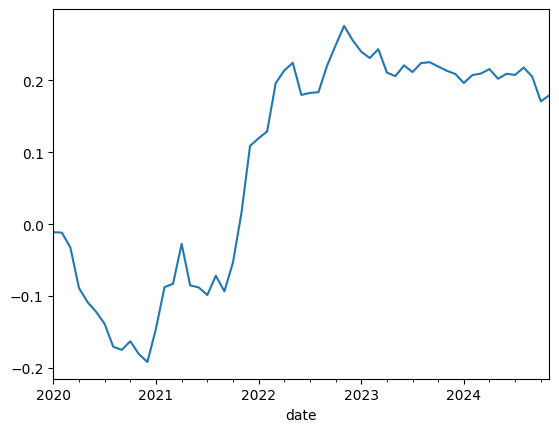

In [1492]:
final_results['ret_ew'].cumsum().plot()

In [1493]:
final_results = final_results.loc[:, ['ret_ew']].rename(columns={'ret_ew' : 'at_gr1'})
final_results.head()

,at_gr1
date,
2020-01-31,-0.011165
2020-02-29,-0.000617
2020-03-31,-0.021059
2020-04-30,-0.055908
2020-05-31,-0.019613


In [1494]:
final_results.loc[final_results['at_gr1'].isna() != True].shape

(59, 1)

In [1495]:
investment_factor_answer =q.load_factors(
    country="usa",
    dataset='factor',
    weighting='ew',
    factors=["at_gr1"],
)

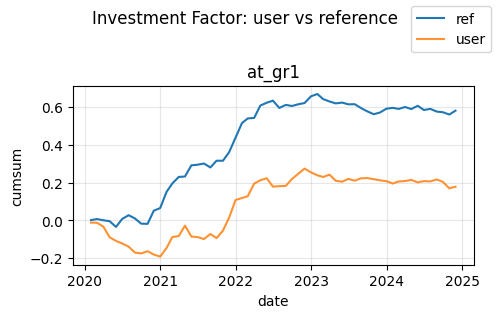

In [1496]:
from qdl import  validator 

report = validator.validate_factor(
    user=final_results,
    reference=investment_factor_answer,
    return_plot=True,
    plot_title="Investment Factor: user vs reference",
)

In [1497]:
print("\n검증 리포트:")
print("관측치수:", report.n_obs, "시작일:", report.date_start, "종료일:", report.date_end)

def _fmt(x):
    return f"{x:.3f}" if x is not None else "nan"

print(
    "mse:", _fmt(report.mse),
    "rmse:", _fmt(report.rmse),
    "mae:", _fmt(report.mae),
    "corr:", _fmt(report.corr),
)

# mse: 0.000 rmse: 0.009 mae: 0.007 corr: 0.979


검증 리포트:
관측치수: 59 시작일: 2020-01-31 00:00:00 종료일: 2024-11-30 00:00:00
mse: 0.001 rmse: 0.036 mae: 0.029 corr: 0.233
